In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Load assemblies metadata file

In [3]:
assemblies = pd.read_csv(os.path.join(os.getcwd(), 'data/assemblies.csv'), index_col='assembly_accession')
assemblies.head()

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000010525.1,438753,7,Azorhizobium caulinodans ORS 571,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,Azorhizobium caulinodans ORS 571,Complete Genome
GCA_000218545.1,593907,11,Cellulomonas gilvus ATCC 13127,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus,Cellulomonas gilvus ATCC 13127,Complete Genome
GCA_000020965.1,309799,14,Dictyoglomus thermophilum H-6-12,Bacteria,Dictyoglomi,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum,Dictyoglomus thermophilum H-6-12,Complete Genome
GCA_000012885.1,338963,19,Pelobacter carbinolicus DSM 2380,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter carbinolicus,Pelobacter carbinolicus DSM 2380,Complete Genome
GCA_001735525.1,23,23,Shewanella colwelliana,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,NaN,Shewanella colwelliana,Scaffold


## Statistics

### Number of unique species

In [4]:
n_unique_species = len(assemblies['species_taxid'].unique())
print(f'Number of assemblies: {len(assemblies):,}')
print(f'Number of unique species: {n_unique_species:,}')

Number of assemblies: 19,741
Number of unique species: 19,228


### Bacteria vs Archaea

In [5]:
domain_count = assemblies[['domain', 'taxid']].groupby('domain').count()
domain_count.columns = ['count']
domain_count

,count
domain,
Archaea,1419
Bacteria,18322


### Taxonomy: phylum

In [6]:
assemblies_tax = assemblies.copy()
assemblies_tax['phylum'] = assemblies_tax['phylum'].fillna('N/A')
phylum_count = assemblies_tax[['domain', 'phylum', 'taxid']].groupby(['domain', 'phylum']).count()
phylum_count.columns = ['count']
phylum_count['percent'] = phylum_count['count'].apply(lambda c: np.round(100 * c / len(assemblies), 1))

top_k = 20
top_k_phylum = phylum_count.sort_values('count', ascending=False).head(top_k)
print(f"Top {top_k} phylum (including N/A), representing {top_k_phylum['percent'].sum():.0f}% of all assemblies:")
top_k_phylum

Top 20 phylum (including N/A), representing 92% of all assemblies:


count  percent
domain   phylum                                 
Bacteria Proteobacteria            6755     34.2
         Firmicutes                3635     18.4
         Bacteroidetes             2302     11.7
         Actinobacteria            1885      9.5
Archaea  Euryarchaeota              999      5.1
Bacteria Cyanobacteria              471      2.4
         N/A                        371      1.9
         Chloroflexi                317      1.6
         Spirochaetes               225      1.1
         Verrucomicrobia            195      1.0
         Tenericutes                157      0.8
         Planctomycetes             127      0.6
Archaea  Crenarchaeota              113      0.6
Bacteria Acidobacteria              109      0.6
Archaea  Thaumarchaeota              96      0.5
Bacteria Nitrospirae                 90      0.5
Archaea  N/A                         75      0.4
Bacteria Deinococcus-Thermus         75      0.4
         Candidatus Omnitrophica     68      0.3
         Elusimicrobia               63      0.3

In [7]:
no_phylum_count = len(assemblies[assemblies['phylum'].isnull()])
no_phylum_percent = 100 * no_phylum_count / len(assemblies)
print(f'Number of species with no phylum information: {no_phylum_count:,} ({no_phylum_percent:.1f}%)')

Number of species with no phylum information: 446 (2.3%)


In [8]:
n_distinct_phylums = len(assemblies[assemblies['phylum'].notnull()]['phylum'].unique())
print(f'Number of distinct phylums (excluding N/A): {n_distinct_phylums:,}')

Number of distinct phylums (excluding N/A): 166


## Assembly level

In [9]:
assembly_levels = assemblies[['assembly_level', 'taxid']].groupby('assembly_level').count()
assembly_levels.columns = ['count']
assembly_levels['percent'] = assembly_levels['count'].apply(lambda c: np.round(100 * c / len(assemblies), 1))
assembly_levels.sort_values('count', ascending=False)

,count,percent
assembly_level,,
Scaffold,10509,53.2
Contig,6361,32.2
Complete Genome,2592,13.1
Chromosome,279,1.4


## Can I open gzipped files from python?

In [45]:
# assembly = 'GCA_900110915.1'  ## Royal jelly?
assembly = 'GCA_000186885.1'

In [46]:
assemblies.loc[assembly]

taxid                                         577650
species_taxid                                    894
organism_name     Desulfobulbus propionicus DSM 2032
domain                                      Bacteria
phylum                                Proteobacteria
class                            Deltaproteobacteria
order                              Desulfobacterales
family                              Desulfobulbaceae
genus                                  Desulfobulbus
species                    Desulfobulbus propionicus
strain            Desulfobulbus propionicus DSM 2032
assembly_level                       Complete Genome
Name: GCA_000186885.1, dtype: object

In [47]:
pfam_path = f'/Users/srom/workspace/nbias/data/sequences/{assembly}/{assembly}_pfam.csv.gz'
pfam_df = pd.read_csv(pfam_path)
print(f'Number of Pfam records: {len(pfam_df):,}')
pfam_df.head()

Number of Pfam records: 7,209


,assembly_accession,protein_id,query,query_id,label
0,GCA_000186885.1,ADW16929.1,MreC,PF04085.14,rod-shape-determining-protein-MreC
1,GCA_000186885.1,ADW18252.1,MrpF_PhaF,PF04066.13,"multisubunit-potassium/proton-antiporter,-PhaF..."
2,GCA_000186885.1,ADW19265.1,Mrr_cat,PF04471.12,restriction-endonuclease
3,GCA_000186885.1,ADW19265.1,Mrr_cat_2,PF13156.6,restriction-endonuclease
4,GCA_000186885.1,ADW19265.1,Mrr_N,PF14338.6,restriction-endonuclease


In [48]:
tigr_path = f'/Users/srom/workspace/nbias/data/sequences/{assembly}/{assembly}_tigr.csv.gz'
tigr_df = pd.read_csv(tigr_path)
print(f'Number of TIGR records: {len(tigr_df):,}')
tigr_df.head()

Number of TIGR records: 1,165


,assembly_accession,protein_id,query,query_id,label
0,GCA_000186885.1,ADW17586.1,TIGR00001,TIGR00001,LSU-ribosomal-protein-L35P
1,GCA_000186885.1,ADW18531.1,TIGR00002,TIGR00002,SSU-ribosomal-protein-S16P
2,GCA_000186885.1,ADW18833.1,TIGR00003,TIGR00003,copper-translocating-P-type-ATPase
3,GCA_000186885.1,ADW16906.1,TIGR00004,TIGR00004,endoribonuclease-L-PSP
4,GCA_000186885.1,ADW18617.1,TIGR00005,TIGR00005,"pseudouridine-synthase,-RluA-family"


In [15]:
assembly = 'GCA_000381985.1'
p = os.path.join(
    os.getcwd(),
    f'data/sequences/{assembly}/{assembly}tri_nucleotide_distance_to_mean.csv',
)
df = pd.read_csv(p)
df.head()

,protein_id,distance,probability
0,KB907337.1_1,0.072647,0.927353
1,KB907337.1_2,0.082018,0.917982
2,KB907337.1_3,0.148301,0.851699
3,KB907337.1_4,0.126539,0.873461
4,KB907337.1_5,0.167576,0.832424


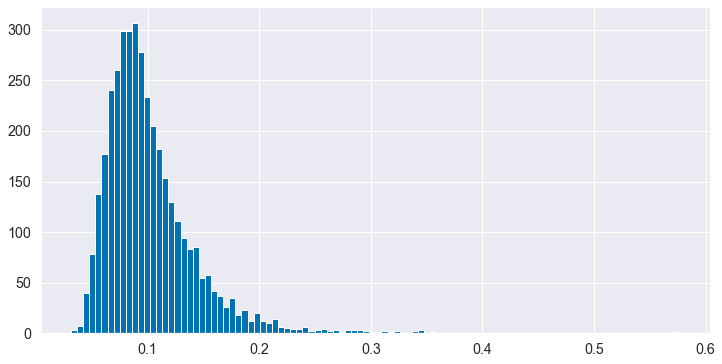

In [18]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
df['distance'].hist(ax=ax, bins=100);

In [20]:
q = df['probability'].quantile(0.99)
v = df[df['probability'] > q]
q, len(v), 100 * len(v) / len(df)

(0.9530257799999999, 39, 1.0182767624020888)